### Import necessary packages

In [1]:
from fastai.vision.all import * 
from fastai.torch_core import TensorBase
import torchvision.models as torchModels
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision.transforms as T
import tifffile as tiff
import kornia
import matplotlib as mp
import numpy as np
import cv2

torch.manual_seed(0) 
random.seed(0)

# Checking the device compatibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # to select device as cpu only put this torch.device('cpu') 
print('Using device:', device)
#print(torch.cuda.get_device_name(0))
#print(torch.__version__)


Using device: cuda


### Initialize the path directories

#### Requirements: The images were sorted and stored in the 'bse' subfolder. The corresponding ground truth was stored in the 'mask' subfolder. 
Note: All the images were saved in 8 bit format and the ground truth image values should be 0 and 1. (refer sort_data.ipynb)

In [2]:
# Replace with your path directory
path = Path('/home/susa03/post_project/post_dataset/synthetic_data/sorted_data/sorted_all/') 
path_images = path/'bse'
file_names = get_image_files(path_images)
path_labels = path/'masks'
label_names = get_image_files(path_labels)

### Define custom function for results visualization

In [3]:
def get_y(file_name):
    # Convert image file path to mask file path
    return path_labels / (file_name.stem.replace("_bse", "_gt") + file_name.suffix)
    
def show_results(pred_samples,target):
    total_samples = target.shape[0]
    
    sample_no = np.random.randint(0,total_samples,1)
    target = target[sample_no[0],:,:]
    
    channel_0 = pred_samples[sample_no,0,:,:]
    channel_0[channel_0>0.5] = 1
    channel_0[channel_0<=0.5] = 0

    channel_1 = pred_samples[sample_no,1,:,:]
    channel_1[channel_1>0.5] = 1
    channel_1[channel_1<=0.5] = 0

    prediction = channel_1 * (1-channel_0)
    prediction = torch.squeeze(prediction)
    
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = torch.sum((prediction == 1) & (target == 1)).item()
    tn = torch.sum((prediction == 0) & (target == 0)).item()
    fp = torch.sum((prediction == 1) & (target == 0)).item()
    fn = torch.sum((prediction == 0) & (target == 1)).item()
    
    accuracy = ((tp + tn) / (tp+tn+fp+fn)) 
    #print(f'Accuracy = {accuracy* 100}%')
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    
    ax1.imshow(target)
    ax1.set_title('Target')
    ax1.axis('off')
    
    ax2.imshow(prediction)  
    ax2.set_title('Prediction')
    ax2.axis('off')
    
    # Calculate false positives and false negatives
    false_positives = np.array(np.logical_and(prediction == 1, target == 0))
    false_negatives = np.array(np.logical_and(prediction == 0, target == 1))

    # Visualize segmentation with false positives (red) and false negatives (blue)
    visualization = np.zeros(prediction.shape + (3,))
    visualization[prediction == 1] = [0, 0.5, 0]  # True positives (green)
    visualization[false_positives==True] = [1, 1, 0]  # False positives (yellow)
    visualization[false_negatives==True] = [1, 0, 0]  # False negatives (red)
    
    # Define the colors for the colorbar
    colors = [(1,0,0),(0,0.5,0),(1,1,0)]  # Red, Green, yellow

    # Define the corresponding values for the colors
    values = [0, 0.5, 1]  

    # Define the names for the colors
    resp_names = ['FN', 'TP', 'FP']

    # Create a custom colormap using the colors and values
    cmap = LinearSegmentedColormap.from_list('CustomColorbar', list(zip(values, colors)),N=3) 
    
    im = ax3.imshow((visualization))
    ax3.set_title('Accuracy map')
    ax3.axis('off')
    
    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3]) 

    # Plot a colorbar using the custom colormap and color names
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
    cbar.set_ticks(values)
    cbar.set_ticklabels(resp_names)

### Data augmentation

#### Random noise

In [4]:
class AddNoise(RandTransform):
    def __init__(self, mean=0., std=1., **kwargs):
        self.std = std
        self.mean = mean
        super().__init__(**kwargs)
    def encodes(self, x:TensorImage):
        return x + torch.randn(x.size(),device=x.device) * self.std + self.mean

#### Random Jitter

In [5]:
class AddJitter(RandTransform):    
    def __init__(self, color_jitter=1, **kwargs):
        super().__init__(**kwargs)
        self._color_jitter = color_jitter            
    def jitter(self, x):
        cjitter = kornia.augmentation.ColorJitter(self._color_jitter, self._color_jitter, self._color_jitter, self._color_jitter)
        return cjitter(x)    
    def encodes(self, x:TensorImage):        
        return self.jitter(x)

#### Gaussian blur

In [6]:
from torchvision.transforms import GaussianBlur

In [7]:
augmentation = [*aug_transforms(
                            max_rotate=90.0,
                            min_zoom=1,
                            max_zoom=3.2),                            
                            #max_lighting=0.9),
                            #p_lighting=0.2),
                            AddNoise(mean=0., std=50.),
                            GaussianBlur(kernel_size=7),
                            Contrast(0)]
                            #AddJitter(color_jitter=0.02)]

'''augmentation = [*aug_transforms(
                            max_rotate=60.0,
                            min_zoom=1,
                            max_zoom=3.2,                            
                            max_lighting=0.9,
                            p_lighting=0.2)
                          ] '''

'augmentation = [*aug_transforms(\n                            max_rotate=60.0,\n                            min_zoom=1,\n                            max_zoom=3.2,                            \n                            max_lighting=0.9,\n                            p_lighting=0.2)\n                          ] '

### Loading the data

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


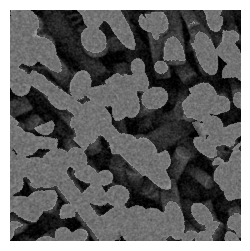

In [8]:
# Label output mask for maskblock implementation
codes = np.array(['background','porus'])
splitter =  TrainTestSplitter (test_size=0.2, random_state=None, stratify=None,train_size=None, shuffle=True)
batchSize = 1
datablocks = DataBlock(blocks=(ImageBlock(cls=PILImageBW), MaskBlock(codes)),
                       get_items = get_image_files,
                       get_y = get_y,
                       splitter=splitter,
                       batch_tfms=augmentation
                      )
data_loader = datablocks.dataloaders(path_images, bs=batchSize,device=device)
data_loader.show_batch(cmap='gray')

### Define evaluation metrics

In [9]:
#Calculate the proportion of correct predictions
def original_ac(predictions, target):
    pred_hot1_decoded = predictions.argmax(dim=1)
    correct_predictions = ( TensorBase(pred_hot1_decoded) == TensorBase(target) )
    correct_predictions = correct_predictions.float()
    return correct_predictions.mean()

#Number of correctly determined porus pixels divided by number of all porus pixels
def porus_ac(predictions, target):   
    pred_hot1_decoded = predictions.argmax(dim=1)
    porosity_in_target = target == 1
    correct_porosity = torch.logical_and( TensorBase(porosity_in_target), TensorBase(pred_hot1_decoded) )
    correct_porosity = correct_porosity.float()       
    return correct_porosity.sum() / porosity_in_target.float().sum()

metrics = [porus_ac, original_ac]

### Choose a suitable architechture as learner

In [10]:
learner = unet_learner(data_loader, resnet34, metrics = metrics,n_in = 1)
learner.loss_func

/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/susa03/post_project/unet_fastai/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FlattenedLoss of CrossEntropyLoss()

### Architechture summary

In [11]:
print(learner.summary())

DynamicUnet (Input shape: 1 x 1 x 850 x 850)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 64 x 425 x 425  
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     1 x 64 x 213 x 213  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

### Find the appropriate learning rate

Message: Learning rate selected is: 0.00015848931798245758


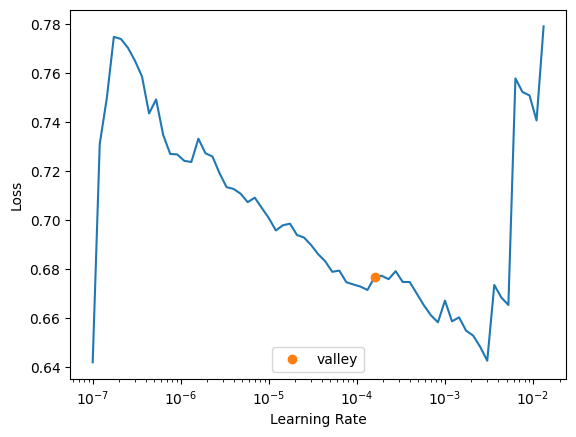

In [12]:
l_r = learner.lr_find()
learning_rate = l_r.valley
print(f"Message: Learning rate selected is: {learning_rate}")

### Save the initial learner

In [13]:
learner.save("model_bse")

Path('models/model_bse.pth')

### Load the learner and train the network 

epoch,train_loss,valid_loss,porus_ac,original_ac,time
0,0.290634,0.499496,0.976730,0.799079,04:53
1,0.212414,0.212571,0.974105,0.916783,04:52
2,0.156245,0.168518,0.928314,0.941471,04:54
3,0.138126,0.143813,0.946480,0.945465,04:52
4,0.144561,0.133136,0.948470,0.949840,04:53


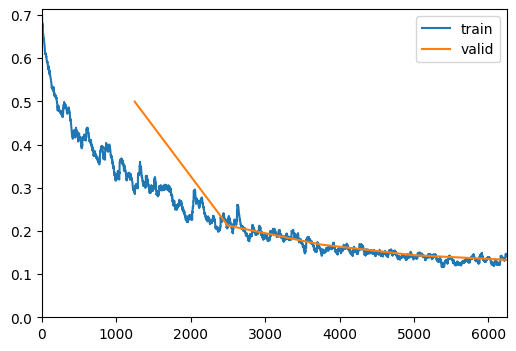

In [14]:
learner.load("model_bse")
epochs = 5
learner.fit_one_cycle(epochs, slice(learning_rate), cbs=[ShowGraphCallback()])

### Export the learner along with trained parameters

In [15]:
learner.export("model_bse_with_data_augmentation.pkl")

### Prediction based on learning

In [16]:
input_img,preds,ground_truth,losses = learner.get_preds(with_loss=True,with_input=True)

### Show the results

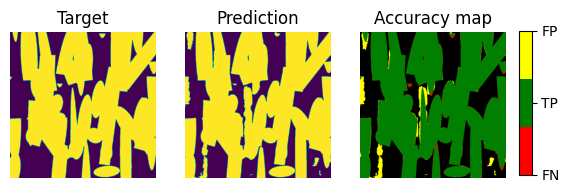

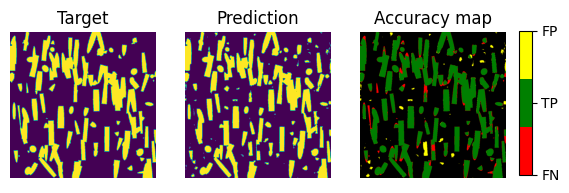

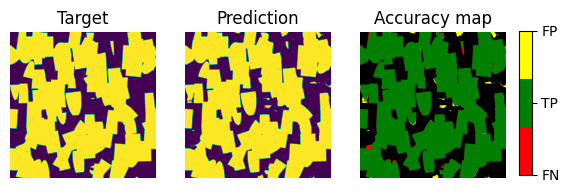

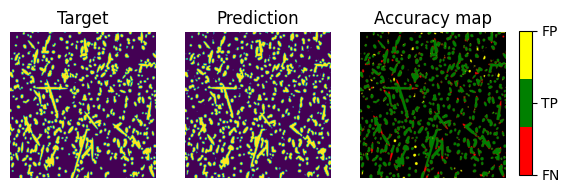

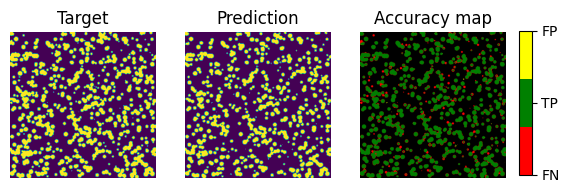

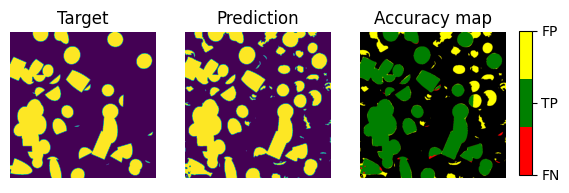

In [17]:
num_results = 6
for i in range(num_results):
    show_results(preds,ground_truth)

### Calculate accuracy of the network

In [18]:
tensor1 = torch.tensor([original_ac(preds,ground_truth)])
value1 = tensor1.item()
print(f'Original Accuracy: {value1*100}%')
tensor2 = torch.tensor([porus_ac(preds,ground_truth)])
value2 = tensor2.item()
print(f'Porus Accuracy: {value2*100}%')

Original Accuracy: 94.69189047813416%
Porus Accuracy: 94.85917687416077%


### Prediction for all the synthetic images and store them in prediction subfolder

In [19]:
''''prediction_path = path/'prediction'/'without_data_augmentation'
for file in file_names:
    _, prediction, _ = learner.predict(file)
    store_path = prediction_path/Path(file.stem + file.suffix) 
    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))'''

"'prediction_path = path/'prediction'/'without_data_augmentation'\nfor file in file_names:\n    _, prediction, _ = learner.predict(file)\n    store_path = prediction_path/Path(file.stem + file.suffix) \n    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))"

### Prediction on real test data

#### Load the test data and predict the mask and store them in a folder

In [20]:
"""#Path to your test image
test_path = Path('/home/susa03/post_project/post_dataset/test_data/ZrO2-P01-from-Repos/')
test_image_path = test_path/'esb-corrected-3x3x3-toolip/'
#test_path = Path('/home/susa03/post_project/post_dataset/test_data/2011-Oct-Porous-carbon-Opel2-Torben-Prill-GV_and_Segmented/')
#test_image_path = test_path/'GV'
prediction_path = test_path/'results'/'bse'
test_images = get_image_files(test_image_path)

for test in test_images:
    _, prediction, _ = learner.predict(test)
    store_path = prediction_path/Path(test.stem + test.suffix) 
    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))"""

"#Path to your test image\ntest_path = Path('/home/susa03/post_project/post_dataset/test_data/ZrO2-P01-from-Repos/')\ntest_image_path = test_path/'esb-corrected-3x3x3-toolip/'\n#test_path = Path('/home/susa03/post_project/post_dataset/test_data/2011-Oct-Porous-carbon-Opel2-Torben-Prill-GV_and_Segmented/')\n#test_image_path = test_path/'GV'\nprediction_path = test_path/'results'/'bse'\ntest_images = get_image_files(test_image_path)\n\nfor test in test_images:\n    _, prediction, _ = learner.predict(test)\n    store_path = prediction_path/Path(test.stem + test.suffix) \n    tiff.imwrite(store_path,np.array(prediction,dtype=np.uint8))"